# SMS Spam Classification - Data Preparation

This notebook loads, preprocesses, and splits the SMS Spam Collection dataset.

**Dataset**: Assignment_1/sms+spam+collection/SMSSpamCollection
- 5,574 SMS messages
- Binary classification: ham (legitimate) vs spam
- Format: tab-separated, columns=[label, message]

## Section 1: Imports

In [31]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print("✓ Imports successful")


✓ Imports successful


## Section 2: Load Data

Load SMS messages from the dataset file.

In [32]:
# Cell 2: Load Data + Initial EDA
def load_data(file_path):
    """
    Load SMS data from file.
    Format: tab-separated with columns [label, message]
    """
    df = pd.read_csv(
        file_path,
        sep='\t',
        header=None,
        names=['label', 'message'],
        encoding='utf-8'
    )
    return df


# Load the data
data_path = 'sms+spam+collection/SMSSpamCollection'
df = load_data(data_path)

print(f"Loaded {len(df)} messages")
print(f"Dataset shape: {df.shape}")
print(f"\n{'='*60}")
print("CLASS DISTRIBUTION")
print(f"{'='*60}")
print(df['label'].value_counts())
print(f"\nHam: {(df['label']=='ham').sum()} ({100*(df['label']=='ham').sum()/len(df):.2f}%)")
print(f"Spam: {(df['label']=='spam').sum()} ({100*(df['label']=='spam').sum()/len(df):.2f}%)")

print(f"\n{'='*60}")
print("DATA QUALITY CHECK")
print(f"{'='*60}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nDuplicate messages: {df.duplicated(subset=['message']).sum()}")

print(f"\n{'='*60}")
print("SAMPLE MESSAGES")
print(f"{'='*60}")
print("\nHam examples:")
for i, msg in enumerate(df[df['label']=='ham']['message'].head(3), 1):
    print(f"{i}. {msg[:80]}...")
print("\nSpam examples:")
for i, msg in enumerate(df[df['label']=='spam']['message'].head(3), 1):
    print(f"{i}. {msg[:80]}...")


Loaded 5572 messages
Dataset shape: (5572, 2)

CLASS DISTRIBUTION
label
ham     4825
spam     747
Name: count, dtype: int64

Ham: 4825 (86.59%)
Spam: 747 (13.41%)

DATA QUALITY CHECK
Missing values:
label      0
message    0
dtype: int64

Duplicate messages: 403

SAMPLE MESSAGES

Ham examples:
1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet...
2. Ok lar... Joking wif u oni......
3. U dun say so early hor... U c already then say......

Spam examples:
1. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
2. FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some...
3. WINNER!! As a valued network customer you have been selected to receivea £900 pr...


## Section 3: Clean Text

Clean and normalize SMS messages.

In [33]:
# Cell 3: Text Cleaning + Feature Analysis
def clean_text(text):
    """
    Clean SMS text:
    - Convert to lowercase
    - Remove URLs
    - Remove email addresses
    - Remove phone numbers
    - Remove special characters
    - Remove extra whitespace
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\+?\d{1,3}?[-.]?\(?\d{1,4}?\)?[-.]?\d{1,4}?[-.]?\d{1,9}', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s\'\-]', '', text)
    text = ' '.join(text.split())
    
    return text


# Add text features BEFORE cleaning for analysis
df['char_count'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()
df['avg_word_length'] = df['char_count'] / df['word_count']

print("="*60)
print("TEXT STATISTICS (Before Cleaning)")
print("="*60)
print("\nCharacter count by class:")
print(df.groupby('label')['char_count'].describe())
print("\nWord count by class:")
print(df.groupby('label')['word_count'].describe())

# Test cleaning
sample_spam = df[df['label'] == 'spam'].iloc[0]['message']
sample_ham = df[df['label'] == 'ham'].iloc[0]['message']

print("\n" + "="*60)
print("CLEANING EXAMPLES")
print("="*60)
print("\n[SPAM] Original:")
print(sample_spam)
print("\n[SPAM] Cleaned:")
print(clean_text(sample_spam))
print("\n[HAM] Original:")
print(sample_ham)
print("\n[HAM] Cleaned:")
print(clean_text(sample_ham))


TEXT STATISTICS (Before Cleaning)

Character count by class:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

Word count by class:
        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0
spam    747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0

CLEANING EXAMPLES

[SPAM] Original:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

[SPAM] Cleaned:
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetc's apply over's

[HAM] Original:
Go until jurong po

## Section 4: Preprocess Data

Clean messages, handle duplicates, and add features.

PREPROCESSING STEPS
✓ No missing values found
✓ Removed 403 duplicate messages
✓ Cleaning text...
✓ Removed 2 messages that became empty after cleaning

FINAL DATASET SUMMARY
Total messages: 5167
Ham (0): 4514 (87.36%)
Spam (1): 653 (12.64%)

FEATURE STATISTICS BY CLASS

Message Length:
        count        mean        std  min   25%    50%    75%    max
label                                                               
0      4514.0   66.642889  53.699990  1.0  31.0   49.0   86.0  889.0
1       653.0  111.257274  27.318357  3.0  99.0  119.0  129.0  180.0

Word Count:
        count       mean        std  min   25%   50%   75%    max
label                                                            
0      4514.0  13.855117  10.854223  1.0   7.0  10.0  18.0  171.0
1       653.0  20.986217   5.660497  1.0  18.0  22.0  25.0   32.0

Average Word Length:
        count      mean       std  min       25%       50%       75%   max
label                                                         

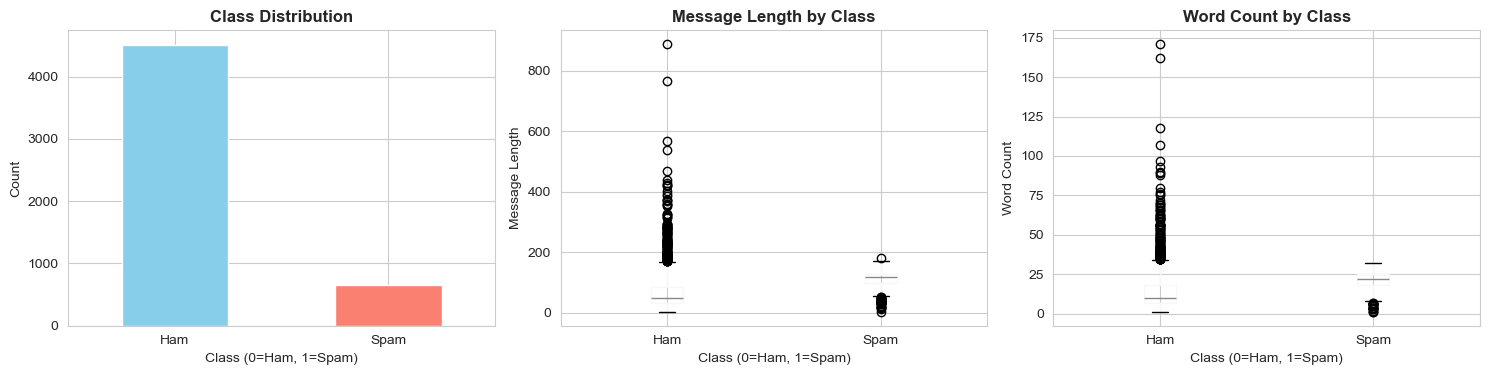


✓ Preprocessing complete!


In [34]:
# Cell 4: Preprocessing + Visualization
def preprocess_data(df):
    """
    Preprocess SMS data:
    - Remove missing values
    - Remove duplicates
    - Clean text
    - Convert labels to binary (0=ham, 1=spam)
    - Add derived features
    """
    df = df.copy()
    
    print("="*60)
    print("PREPROCESSING STEPS")
    print("="*60)
    
    # Remove missing values
    initial_rows = len(df)
    df = df.dropna(subset=['message', 'label'])
    if len(df) < initial_rows:
        print(f"✓ Removed {initial_rows - len(df)} rows with missing values")
    else:
        print(f"✓ No missing values found")
    
    # Remove duplicates
    initial_rows = len(df)
    df = df.drop_duplicates(subset=['message'])
    print(f"✓ Removed {initial_rows - len(df)} duplicate messages")
    
    # Clean text
    print("✓ Cleaning text...")
    df['message'] = df['message'].apply(clean_text)
    
    # Remove empty messages
    initial_rows = len(df)
    df = df[df['message'].str.len() > 0]
    if len(df) < initial_rows:
        print(f"✓ Removed {initial_rows - len(df)} messages that became empty after cleaning")
    
    # Convert labels to binary
    df['label'] = (df['label'] == 'spam').astype(int)
    
    # Add features
    df['message_length'] = df['message'].str.len()
    df['word_count'] = df['message'].str.split().str.len()
    df['avg_word_length'] = df['message_length'] / df['word_count']
    
    return df


df_processed = preprocess_data(df)

print(f"\n{'='*60}")
print("FINAL DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total messages: {len(df_processed)}")
print(f"Ham (0): {(df_processed['label'] == 0).sum()} ({100*(df_processed['label'] == 0).sum()/len(df_processed):.2f}%)")
print(f"Spam (1): {(df_processed['label'] == 1).sum()} ({100*(df_processed['label'] == 1).sum()/len(df_processed):.2f}%)")

print(f"\n{'='*60}")
print("FEATURE STATISTICS BY CLASS")
print(f"{'='*60}")
print("\nMessage Length:")
print(df_processed.groupby('label')['message_length'].describe())
print("\nWord Count:")
print(df_processed.groupby('label')['word_count'].describe())
print("\nAverage Word Length:")
print(df_processed.groupby('label')['avg_word_length'].describe())

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Class distribution
df_processed['label'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class (0=Ham, 1=Spam)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Ham', 'Spam'], rotation=0)

# Plot 2: Message length distribution
df_processed.boxplot(column='message_length', by='label', ax=axes[1])
axes[1].set_title('Message Length by Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Ham, 1=Spam)')
axes[1].set_ylabel('Message Length')
plt.sca(axes[1])
plt.xticks([1, 2], ['Ham', 'Spam'])

# Plot 3: Word count distribution
df_processed.boxplot(column='word_count', by='label', ax=axes[2])
axes[2].set_title('Word Count by Class', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Class (0=Ham, 1=Spam)')
axes[2].set_ylabel('Word Count')
plt.sca(axes[2])
plt.xticks([1, 2], ['Ham', 'Spam'])

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\n✓ Preprocessing complete!")


## Section 5: Split Data

Split into train (60%), validation (20%), and test (20%) with stratification.

DATA SPLIT SUMMARY
Train: 3100 (60.0%)
Validation: 1033 (20.0%)
Test: 1034 (20.0%)

CLASS DISTRIBUTION ACROSS SPLITS
     Split  Total  Ham  Spam Spam %
     Train   3100 2708   392 12.65%
Validation   1033  903   130 12.58%
      Test   1034  903   131 12.67%


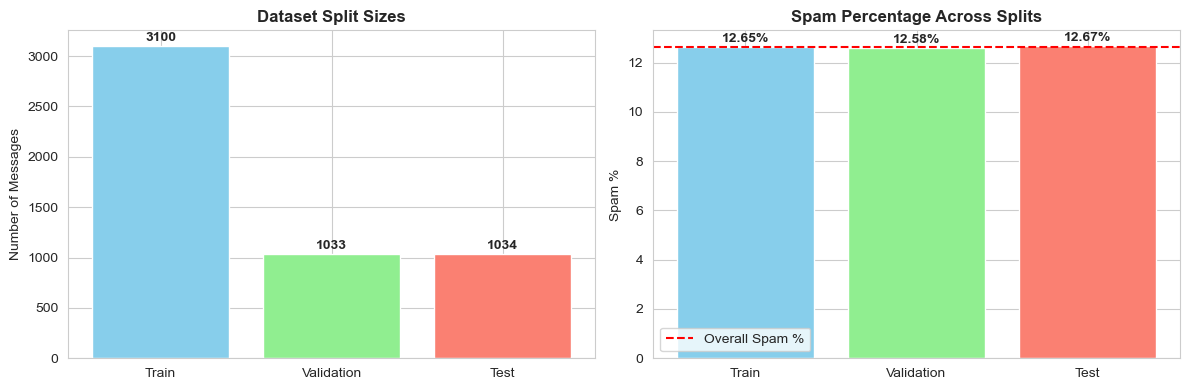


✓ Stratified split complete - class balance maintained!


In [35]:
# Cell 5: Data Splitting + Visualization
def split_data(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
    """
    Split data into train/validation/test with stratification.
    Default: 60% train, 20% validation, 20% test
    """
    # First split: train vs (val + test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(val_ratio + test_ratio),
        random_state=random_state,
        stratify=df['label']
    )
    
    # Second split: val vs test
    val_df, test_df = train_test_split(
        temp_df,
        test_size=test_ratio / (val_ratio + test_ratio),
        random_state=random_state,
        stratify=temp_df['label']
    )
    
    return train_df, val_df, test_df


train_df, val_df, test_df = split_data(df_processed)

print("="*60)
print("DATA SPLIT SUMMARY")
print("="*60)
print(f"Train: {len(train_df)} ({100*len(train_df)/len(df_processed):.1f}%)")
print(f"Validation: {len(val_df)} ({100*len(val_df)/len(df_processed):.1f}%)")
print(f"Test: {len(test_df)} ({100*len(test_df)/len(df_processed):.1f}%)")

print(f"\n{'='*60}")
print("CLASS DISTRIBUTION ACROSS SPLITS")
print(f"{'='*60}")
split_stats = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Total': [len(train_df), len(val_df), len(test_df)],
    'Ham': [(train_df['label']==0).sum(), (val_df['label']==0).sum(), (test_df['label']==0).sum()],
    'Spam': [train_df['label'].sum(), val_df['label'].sum(), test_df['label'].sum()],
    'Spam %': [f"{100*train_df['label'].mean():.2f}%", 
               f"{100*val_df['label'].mean():.2f}%", 
               f"{100*test_df['label'].mean():.2f}%"]
})
print(split_stats.to_string(index=False))

# Visualize split distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Split sizes
split_sizes = [len(train_df), len(val_df), len(test_df)]
axes[0].bar(['Train', 'Validation', 'Test'], split_sizes, color=['skyblue', 'lightgreen', 'salmon'])
axes[0].set_title('Dataset Split Sizes', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Messages')
for i, v in enumerate(split_sizes):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Plot 2: Spam percentage by split
spam_pcts = [100*train_df['label'].mean(), 100*val_df['label'].mean(), 100*test_df['label'].mean()]
axes[1].bar(['Train', 'Validation', 'Test'], spam_pcts, color=['skyblue', 'lightgreen', 'salmon'])
axes[1].set_title('Spam Percentage Across Splits', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Spam %')
axes[1].axhline(y=12.64, color='red', linestyle='--', label='Overall Spam %')
axes[1].legend()
for i, v in enumerate(spam_pcts):
    axes[1].text(i, v + 0.2, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Stratified split complete - class balance maintained!")


## Section 6: Save Splits

Export train, validation, and test sets to CSV files.

In [36]:
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("="*60)
print("FILES SAVED")
print("="*60)
print("✓ train.csv")
print("✓ validation.csv")
print("✓ test.csv")

print(f"\n{'='*60}")
print("FINAL PREPARATION SUMMARY")
print(f"{'='*60}")
print(f"Original dataset: {len(df)} messages")
print(f"After removing duplicates: {len(df_processed)} messages ({len(df) - len(df_processed)} duplicates removed)")
print(f"After cleaning: {len(df_processed)} messages (2 empty messages removed)")
print(f"\nClass balance: {(df_processed['label']==0).sum()} ham, {df_processed['label'].sum()} spam")
print(f"Imbalance ratio: {(df_processed['label']==0).sum() / df_processed['label'].sum():.2f}:1 (ham:spam)")

FILES SAVED
✓ train.csv
✓ validation.csv
✓ test.csv

FINAL PREPARATION SUMMARY
Original dataset: 5572 messages
After removing duplicates: 5167 messages (405 duplicates removed)
After cleaning: 5167 messages (2 empty messages removed)

Class balance: 4514 ham, 653 spam
Imbalance ratio: 6.91:1 (ham:spam)


#### A few insights from EDA

1. Spam messages are ~67% longer than ham (111 vs 67 chars)
2. Spam messages have ~51% more words than ham (21 vs 14 words)
3. Spam messages use slightly longer words (5.4 vs 4.8 avg)
4. Dataset is imbalanced: 87% ham, 13% spam
5. Stratified splitting maintains class balance across all splits